# Loading Imports

In [1]:
# adding root folder to path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# python imports
import pickle

# third-party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

## Utils

In [3]:
def get_y_true(y_test, target):
    return [1 if y == target else 0 for y in y_test]

# Prep

In [4]:
classes = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']
colors = ['#21b803', '#fbbc04', '#f66e0b', '#f41907']

n_classes = len(classes)

In [5]:
uncalibrated_results = None
calibrated_sigmoid_results = None
calibrated_isotonic_results = None

with open('results/uncalibrated_results.pickle', 'rb') as file:
    uncalibrated_results = pickle.load(file)
    
with open('results/calibrated_sigmoid_results.pickle', 'rb') as file:
    calibrated_sigmoid_results = pickle.load(file)
    
with open('results/calibrated_isotonic_results.pickle', 'rb') as file:
    calibrated_isotonic_results = pickle.load(file)

In [6]:
clf_list = [
    (None, uncalibrated_results, 'Gradient Boosting'),
    (None, calibrated_sigmoid_results, 'Gradient Boosting + Sigmoide'),
    (None, calibrated_isotonic_results, 'Gradient Boosting + Isotônica')
]

# Accuracy

In [7]:
for (clf, result, name) in clf_list:
    print(f"{name} acc: {np.mean(result['acc']):.2f} (std={np.std(result['acc']):.2f})")

Gradient Boosting acc: 0.73 (std=0.05)
Gradient Boosting + Sigmoide acc: 0.72 (std=0.06)
Gradient Boosting + Isotônica acc: 0.75 (std=0.05)


# [Expected Calibration Error](https://jamesmccaffrey.wordpress.com/2021/01/22/how-to-calculate-expected-calibration-error-for-multi-class-classification/)

In [8]:
for (clf, result, name) in clf_list:
    print(f"{name} ece: {np.mean(result['ece']):.2f} (std={np.std(result['ece']):.2f})")

Gradient Boosting ece: 0.17 (std=0.05)
Gradient Boosting + Sigmoide ece: 0.22 (std=0.06)
Gradient Boosting + Isotônica ece: 0.13 (std=0.04)


# [Brier Loss](https://stackoverflow.com/questions/71770524/optimize-classifier-for-multiclass-brier-score-instead-of-accuracy)

In [9]:
for (clf, result, name) in clf_list:
    print(f"{name} brier_loss: {np.mean(result['brier_loss']):.2f} (std={np.std(result['brier_loss']):.2f})")

Gradient Boosting brier_loss: 0.42 (std=0.09)
Gradient Boosting + Sigmoide brier_loss: 0.46 (std=0.03)
Gradient Boosting + Isotônica brier_loss: 0.40 (std=0.06)


# [Calibration Curve](https://scikit-learn.org/stable/modules/calibration.html)

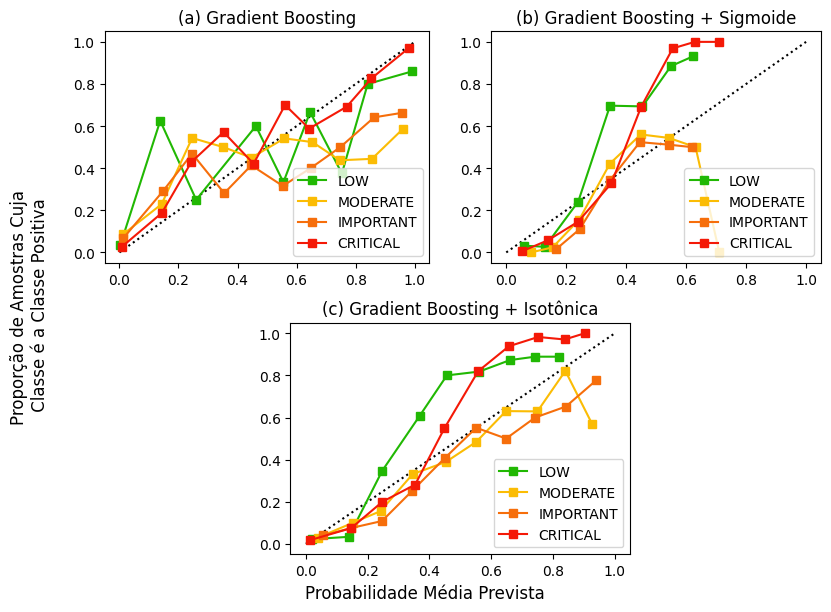

In [10]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)

# fig.suptitle('Curvas de Calibração', size=14)
fig.supylabel('Proporção de Amostras Cuja\n Classe é a Classe Positiva', horizontalalignment='center', size=12)
fig.supxlabel('Probabilidade Média Prevista', size=12)

gs = GridSpec(2, 4, figure=fig, wspace=0.05, hspace=0.05)

axes = list()
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax = fig.add_subplot(gs[1, 1:3])
axes.append(ax)

items = ['(a)', '(b)', '(c)']

for ax, item, (cls, result, name) in zip(axes, items, clf_list):
    
    ax.set_title(f'{item} {name}')
    
    ax.plot([0, 1], [0, 1], 'k:')

    for target, c in zip(range(n_classes), colors):
        prob_pos = result[target]
        
        fraction_of_positives, mean_predicted_value =\
            calibration_curve(get_y_true(result['y_test'], target), prob_pos, n_bins=10)

        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=classes[target], color=c)

    ax.legend(loc='lower right')

plt.savefig(f'calibration-plots.pdf', bbox_inches='tight', dpi=1200)
plt.show()

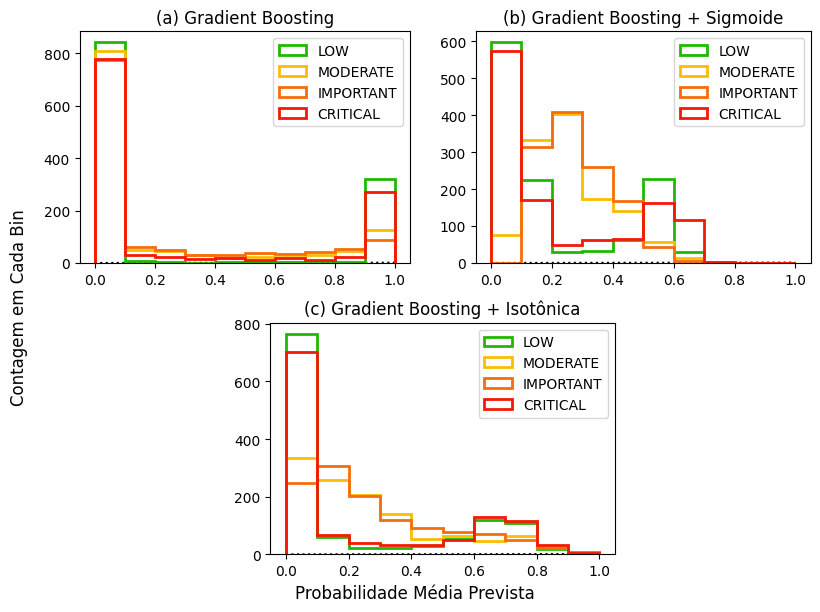

In [11]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)

# fig.suptitle('Histograma de Probabilidade Prevista', size=14)
fig.supylabel('Contagem em Cada Bin', horizontalalignment='center', size=12)
fig.supxlabel('Probabilidade Média Prevista', size=12)

gs = GridSpec(2, 4, figure=fig, wspace=0.05, hspace=0.05)

axes = list()
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax = fig.add_subplot(gs[1, 1:3])
axes.append(ax)

for ax, item, (cls, result, name) in zip(axes, items, clf_list):
    
    ax.set_title(f'{item} {name}')
    
    ax.plot([0, 1], [0, 1], 'k:')

    for target, c in zip(range(n_classes), colors):
        prob_pos = result[target]
        ax.hist(prob_pos, range=(0, 1), bins=10, color=c, label=classes[target], histtype="step", lw=2)

    ax.legend(loc='upper right')

plt.savefig(f'predicted-probability-histogram.pdf', bbox_inches='tight', dpi=1200)
plt.show()

# [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

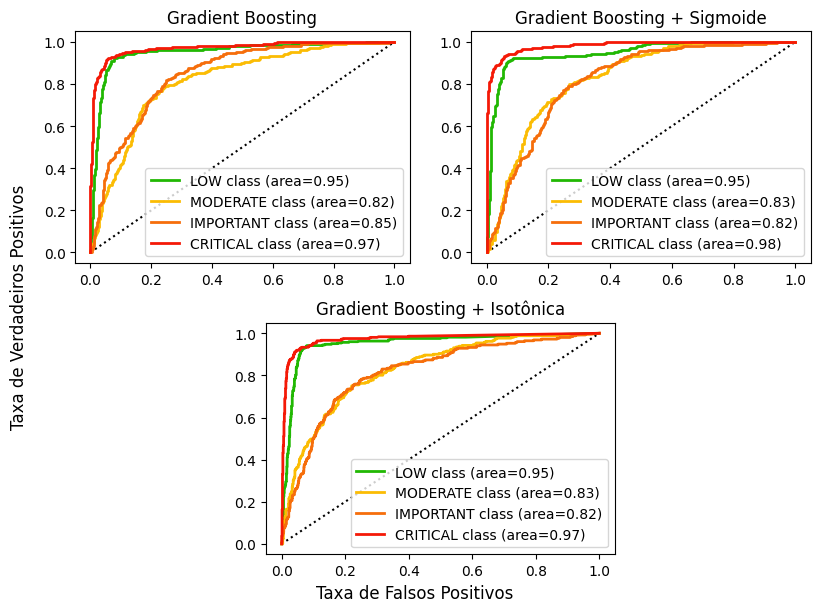

In [12]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)

# fig.suptitle('Característica Operacional do Receptor (ROC)', size=14)
fig.supylabel('Taxa de Verdadeiros Positivos', horizontalalignment='center', size=12)
fig.supxlabel('Taxa de Falsos Positivos', size=12)

gs = GridSpec(2, 4, figure=fig, wspace=0.05, hspace=0.05)

axes = list()
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax = fig.add_subplot(gs[1, 1:3])
axes.append(ax)

for ax, item, (cls, result, name) in zip(axes, items, clf_list):
    
    ax.set_title(f'{item} {name}')
    
    y_score = result['proba']

    # computing ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(get_y_true(result['y_test'], i), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # aggregating false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # interpolating ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)
    
    ax.set_title(name)
    ax.plot([0, 1], [0, 1], 'k:')
    
    for i, cls, c in zip(range(len(classes)), classes, colors):
        ax.plot(fpr[i], tpr[i], color=c, lw=2, label=f'{cls} class (area={roc_auc[i]:0.2f})')

    ax.legend(loc='lower right')

plt.savefig('receiver-operating-characteristic.pdf', bbox_inches='tight', dpi=1200)
plt.show()